If you run in jupyter, turn 

```
colab = False
```



In [1]:
colab = False

In [2]:
if colab:
    !pip install gym pyvirtualdisplay > /dev/null 2>&1
    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
    !apt-get update > /dev/null 2>&1
    !apt-get install cmake > /dev/null 2>&1
    !pip install --upgrade setuptools 2>&1
    !pip install ez_setup > /dev/null 2>&1

In [3]:
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    
    %cd /content/drive/MyDrive/Colab\ Notebooks/drlcourse-main/day2/q_learning
    !ls

# Tabular Q-learning Practice

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from discrete_pendulum import DiscretePendulumEnv

# 0. Basic definitions

## 0.0. Q-table

In [5]:
class QTable:
    def __init__(self, num_states, num_actions, gamma=0.99, pth=None):
        self.gamma = gamma
        if pth is None:
            self.Q = -300. * np.ones(shape=(num_states, num_actions))
        else:
            self.Q = np.load(pth, allow_pickle=True)

    def update(self, state, action, reward, next_state, done, alpha):
        # update Q-table according to the following update rule:
        # Q(s, a) <- Q(s, a) + alpha * (r + gamma max_{a'} Q(s', a') - Q(s, a))
        # TODO: build target value corresponding to below update rule
        target = reward + self.gamma*(1-done)*(np.max(self.Q[next_state, :] - self.Q[state,action]))
        self.Q[state, action] += alpha * target

    def act(self, state):
        return np.argmax(self.Q[state])

    def save(self, pth=None):
        if pth is None:
            pth = './table.npy'
        np.save(pth, self.Q)

    @property
    def value_ftn(self):
        return np.max(self.Q, axis=1)

## 0.1. Stepsize rule & Exploration Schedule

In [6]:
# Stepsize rule!
class VisitCountStepsizeSchedule:
    def __init__(self, deg=1.0):
        # polynomial stepsize schedule : $\Theta(N_t(s, a)^{-d})$
        # $N_t(s, a)$ is the number of visits of (s, a)-pair until step t
        # to satisfy Robbins-Monro condition, d must satisfy $d \in (1/2, 1]$
        assert .5 < deg <= 1
        self.deg = deg

    def __call__(self, n):
        return 1. / ((n + 1.) ** self.deg)

# Exploration schedule
class LinearExplorationSchedule:
    def __init__(self, rollout_len, initial_epsilon=1., final_epsilon=0.02):
        # linear exploration schedule
        self.decrement = (initial_epsilon - final_epsilon) / rollout_len
        self.initial_epsilon = initial_epsilon
        self.final_epsilon = final_epsilon

    # define this as callable object so that the schedule is stateless
    def __call__(self, t):
        # TODO: implement linear decaying rule at [Fill here]
        # max function is taken to double-check epsilon is above final epsilon
        return max(self.initial_epsilon - self.decrement*t, self.final_epsilon)
    
class ExponentialExplorationSchedule:
    def __init__(self, decay_rate, initial_epsilon=1., final_epsilon=0.02):
        self.decay_rate = decay_rate
        self.initial_epsilon = initial_epsilon
        self.final_epsilon = final_epsilon

    def __call__(self, t):
        # TODO : implement exponential decaying rule at [Fill here]
        return max(self.initial_epsilon*(self.decay_rate**t), self.final_epsilon)

# 1. Q-learning

In [7]:
import gym

env = gym.make('Taxi-v3')
num_states = env.observation_space.n
num_actions = env.action_space.n
gamma = 0.99

# Our agent is QTable!
agent = QTable(num_states=env.observation_space.n, num_actions=env.action_space.n, gamma=gamma)
rollout_len = 1000000

Main RL loop! - recall generic structure of RL!

In [8]:
# Main RL loop! - recall the structure!
s = env.reset()
for t in tqdm(range(rollout_len + 1)):
    # epsilon-greedy with 0.5 noise
    eps = np.random.rand()
    if eps < 0.5:
        a = env.action_space.sample()
    else:
        a = agent.act(state=s)
    
    # Perform action
    s_next, r, done, _ = env.step(action=a)
    
    # Update agent
    agent.update(state=s, action=a, reward=r, next_state=s_next, done=done, alpha=0.99)
    
    s = s_next
    if done or t % 2000 == 0:
        s = env.reset()

100%|██████████| 1000001/1000001 [00:47<00:00, 21117.25it/s]


Test policy

In [9]:
# Test 
taxi = gym.make('Taxi-v3')
state = taxi.reset()

print('+=======  Simulation result  =======')
taxi.render()
for t in range(100):
   
    action = agent.act(state)
    
    # Simulate 1 step
    state, reward, done, info = taxi.step(action) 
   
    # done is used to check terminal condition    
    if done:
      taxi.render()
      print("\n+=======  Success!   =======+")
      break

# Close environment
taxi.close()

+=======  Simulation result  =======
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

+=======  Success!   =======+


# 2. Test on discrete pendulum environment

In [10]:
env = DiscretePendulumEnv()
num_states = env.observation_space.n
num_actions = env.action_space.n
gamma = 0.99

# Our agent is QTable!
agent = QTable(num_states=env.observation_space.n, num_actions=env.action_space.n, gamma=gamma)
rollout_len = 5000000

# epsilon and alpha schedule
epsilon_schedule = LinearExplorationSchedule(rollout_len, final_epsilon=0.4)
# TODO : alternative
# epsilon_schedule = ExponentialExplorationSchedule(decay_rate=0.99, final_epsilon=0.02)

alpha_schedule = VisitCountStepsizeSchedule(deg=0.5001)

In [11]:
# save visit counts N(s, a) of all state-action pairs
visit_count = np.zeros(shape=(num_states, num_actions))

# For logging
checkpoint_interval = rollout_len // 20

# Main RL loop! - recall the structure!
s = env.reset()
for t in tqdm(range(rollout_len + 1)):
    # epsilon-greedy method from the agent action
    eps = np.random.rand()
    if eps < epsilon_schedule(t):
        a = env.action_space.sample()
    else:
        a = agent.act(state=s)
    
    # Perform action
    s_next, r, done, _ = env.step(action=a)
    
    # Update agent
    n = visit_count[s, a]
    agent.update(state=s, action=a, reward=r, next_state=s_next, done=done, alpha=alpha_schedule(n))
    visit_count[s, a] += 1
    
    s = s_next
    if done or t % 2000 == 0:
        s = env.reset()
    # For logging
    if t % checkpoint_interval == 0:
        agent.save()

100%|██████████| 5000001/5000001 [15:54<00:00, 5238.07it/s]


## 2.0. Visualization

In [12]:
if colab:
  import gym
  from gym.wrappers import Monitor
  import glob
  import io
  import base64
  from IPython.display import HTML
  from pyvirtualdisplay import Display
  from IPython import display as ipythondisplay

  display = Display(visible=0, size=(1400, 900))
  display.start()

  def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
      mp4 = mp4list[0]
      video = io.open(mp4, 'r+b').read()
      encoded = base64.b64encode(video)
      ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                  loop controls style="height: 400px;">
                  <source src="data:video/mp4;base64,{0}" type="video/mp4" />
              </video>'''.format(encoded.decode('ascii'))))
    else: 
      print("Could not find video")
      

  def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

  env = wrap_env(env)

In [14]:
ep_len = 600

# for logging
trajectory = np.zeros((ep_len, 2))      
reward = 0.

np.random.seed(2021)
env = DiscretePendulumEnv()
if colab:
  env = wrap_env(env)
s = env.reset(deterministic=True)

# test learned result!
for t in range(ep_len):
    trajectory[t] = np.copy(env.x)
    a = agent.act(s)
    s, r, _, _ = env.step(a)
    reward += (gamma ** t) * r
    env.render()

print('total reward =', reward)
env.close()

if colab:
  show_video()

NameError: name 'glPushMatrix' is not defined

## 2.1. Trajectory Plot

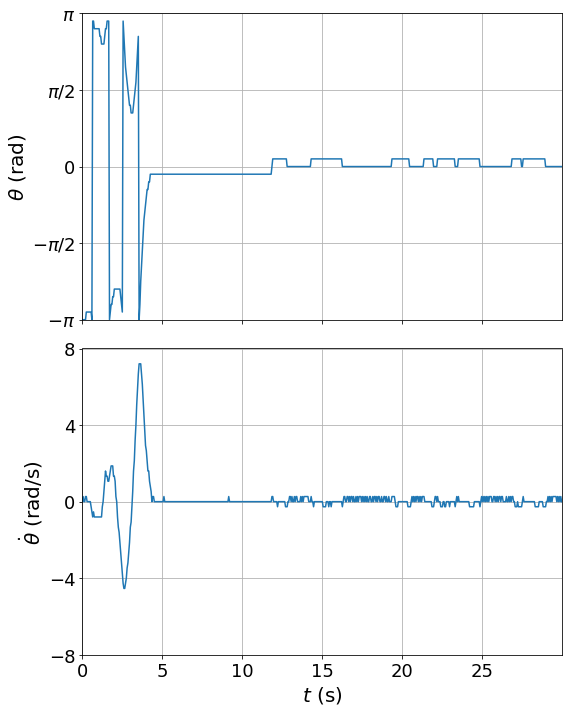

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
x = env.dt * np.arange(ep_len)
ylabels = [r'$\theta$ (rad)', r'$\dot\theta$ (rad/s)']
ax[1].set_xlabel(r'$t$ (s)', fontsize=20)
ax[0].set_ylim(-np.pi, np.pi)
ax[1].set_ylim(-8., 8.)
ax[0].set_yticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi])
ax[0].set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
ax[1].set_yticks([-8, -4, 0, 4, 8])
for i in range(2):
    ax[i].plot(x, trajectory[:, i])
    ax[i].set_xlim(0, x[-1])
    ax[i].grid(True)
    ax[i].set_ylabel(ylabels[i], fontsize=20)
    ax[i].tick_params(axis='both', which='major', labelsize=18)
fig.tight_layout()

## 2.2. Q-learning Result vs Optimal Solution

In [ ]:
optimal_agent = QTable(num_states=env.observation_space.n, num_actions=env.action_space.n, pth='./optimum.npy')
if colab:
  env = wrap_env(DiscretePendulumEnv())

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
ep_len = 600
# test learned result!
trajectory = np.zeros((ep_len, 2))      # store continuous states
reward = 0.

s = env.reset(deterministic=True)

for t in range(ep_len):
    trajectory[t] = np.copy(env.x)
    a = optimal_agent.act(s)
    s, r, _, _ = env.step(a)
    reward += (gamma ** t) * r
    env.render()
print('total reward =', reward)
env.close()

if colab:
  show_video()

total reward = -235.11598847789196
